Algorithm 4: Heeger-Bergen texture synthesis algorithm for grayscale images (without extension)

Input : Number of scales P, number of orientations Q, texture image u of size M × N such that M and N are multiples of 2P, number of iterations Niter

Output: Texture image v of size M × N
1. Input analysis:
2. Compute and store the steerable pyramid with P scales and Q orientations of the input
texture u.
3. Output synthesis:
4. Initialize v with a Gaussian white noise.
5. Match the gray-level histogram of v with the gray-level histogram of the input u.
6. for iteration i = 1 to Niter do
  7. Compute the steerable pyramid of v.
  8. For each of the P Q + 2 images of this pyramid, apply histogram matching with the
  corresponding image of the pyramid of u.
  9. Apply the image reconstruction algorithm to this new histogram-matched pyramid and
  store the obtained image in v.
  10. Match the gray-level histogram of v with the gray-level histogram of the input u.
11. end
12. Return v.

[The Heeger-Bergen Pyramid-Based Texture Synthesis
Algorithm](https://www.ipol.im/pub/art/2014/79/article_lr.pdf)

[Project Proposal Feedback](https://docs.google.com/document/d/17ZEk0MIPoon37vx_fQ-ej7ngJV12crpKNdqyOjjNJ-A/edit)




In [2]:
import numpy as np
import cv2
import pyrtools as pt
import matplotlib.pyplot as plt


I think we can use the SCFpyr_NumPy.py in steerable folder instead of using pyrtools:

https://github.com/tomrunia/PyTorchSteerablePyramid

https://github.com/andreydung/Steerable-filter


In [66]:
image = cv2.cvtColor(cv2.imread("test/paper3.png"), cv2.COLOR_BGR2GRAY)
P = 3
Q = 4
pyr = pt.pyramids.SteerablePyramidFreq(image, P, Q)

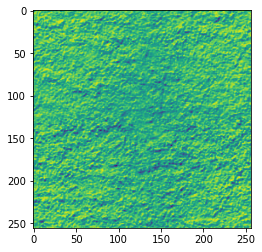

In [67]:
plt.imshow(image)

In [68]:
for key, val in pyr.pyr_coeffs.items():
    print(key, val.shape)

residual_highpass (256, 256)
(0, 0) (256, 256)
(0, 1) (256, 256)
(0, 2) (256, 256)
(0, 3) (256, 256)
(0, 4) (256, 256)
(1, 0) (128, 128)
(1, 1) (128, 128)
(1, 2) (128, 128)
(1, 3) (128, 128)
(1, 4) (128, 128)
(2, 0) (64, 64)
(2, 1) (64, 64)
(2, 2) (64, 64)
(2, 3) (64, 64)
(2, 4) (64, 64)
residual_lowpass (32, 32)


In [69]:
def steerable_pyramid(image, P, Q):
    pyr = pt.pyramids.SteerablePyramidFreq(image, P, Q)
    return pyr

In [70]:
def image_reconstruction(pyr):
    res = pyr.recon_pyr()
    return res

In [71]:
import numpy as np
data = np.random.rand(32, 32)
data.shape

(32, 32)

In [72]:
np.argsort(data)
np.unravel_index(np.argsort(data, axis=None), data.shape)

(array([12,  3,  3, ..., 15, 22, 14]), array([31, 19,  9, ..., 20,  4,  9]))

In [88]:
import copy

def histogram_matching(v, u):
    # align u onto the histogram of v
    assert v.size == u.size
    L = u.size
    # get v indices in sorted order
    indices_v = np.unravel_index(np.argsort(v, axis=None), v.shape)
    # get u indices in sorted order
    indices_u = np.unravel_index(np.argsort(u, axis=None), u.shape)
    for k in range(L):
        row_u, col_u = indices_u[0][k], indices_u[1][k]
        row_v, col_v = indices_v[0][k], indices_v[1][k]
        u[row_u][col_u] = v[row_v][col_v]
    return u

def heeger_bergen_texture_synthesis(texture, P, Q, Niter):
    # Input analysis
    pyramid_texture = steerable_pyramid(texture, P, Q)
    # Output synthesis
    texture_synth = np.random.normal(size=texture.shape)  # Initialize v with Gaussian white noise
    # Match the gray-level histogram of v with u
    texture_synth = histogram_matching(texture, texture_synth)
    for i in range(Niter):
        # Compute the steerable pyramid of v
        pyramid_texture_synth = steerable_pyramid(texture_synth, P, Q)
        # Apply histogram matching for each image in the pyramid
        for pq_key in pyramid_texture_synth.pyr_coeffs:
            matched_image = histogram_matching(pyramid_texture.pyr_coeffs[pq_key], pyramid_texture_synth.pyr_coeffs[pq_key])
            pyramid_texture_synth.pyr_coeffs[pq_key] = copy.deepcopy(matched_image)
        # Apply image reconstruction algorithm
        texture_synth = image_reconstruction(pyramid_texture_synth)
        # Match the gray-level histogram of v with u
        texture_synth = histogram_matching(texture, texture_synth)
    return texture_synth

In [89]:
def histogram_matching_scaled(v, u, width_scale, height_scale):
    # align u onto the histogram of v
    factor_scale = width_scale * height_scale
    assert v.size * factor_scale == u.size
    L = v.size
    # get v indices in sorted order
    indices_v = np.unravel_index(np.argsort(v, axis=None), v.shape)
    # get u indices in sorted order
    indices_u = np.unravel_index(np.argsort(u, axis=None), u.shape)
    for k in range(L):
        # assign k * factor_scale to k * factor_scale + factor_scale
        row_v, col_v = indices_v[0][k], indices_v[1][k]
        for _ in range(k * factor_scale, k * factor_scale + factor_scale):
            row_u, col_u = indices_u[0][_], indices_u[1][_]
            u[row_u][col_u] = v[row_v][col_v]
    return u


def heeger_bergen_texture_synthesis_scaled(texture, P, Q, Niter, width_scale=1, height_scale=1):
    # Input analysis
    pyramid_texture = steerable_pyramid(texture, P, Q)
    # Output synthesis
    texture_synth = np.random.normal(size=(texture.shape[0] * height_scale, texture.shape[1] * width_scale))  # Initialize v with Gaussian white noise
    print(texture.shape, texture_synth.shape)
    # Match the gray-level histogram of v with u
    texture_synth = histogram_matching_scaled(texture, texture_synth, width_scale=width_scale, height_scale=height_scale)
    for i in range(Niter):
        # Compute the steerable pyramid of v
        pyramid_texture_synth = steerable_pyramid(texture_synth, P, Q)
        # Apply histogram matching for each image in the pyramid
        for pq_key in pyramid_texture_synth.pyr_coeffs:
            matched_image = histogram_matching_scaled(pyramid_texture.pyr_coeffs[pq_key], pyramid_texture_synth.pyr_coeffs[pq_key], width_scale=width_scale, height_scale=height_scale)
            pyramid_texture_synth.pyr_coeffs[pq_key] = copy.deepcopy(matched_image)
        # Apply image reconstruction algorithm
        texture_synth = image_reconstruction(pyramid_texture_synth)
        # Match the gray-level histogram of v with u
        texture_synth = histogram_matching_scaled(texture, texture_synth, width_scale=width_scale, height_scale=height_scale)
    return texture_synth

In [92]:
P = 3
Q = 3
image_synth = heeger_bergen_texture_synthesis_scaled(image, P, Q, Niter, width_scale=2, height_scale=3)

(256, 256) (768, 512)


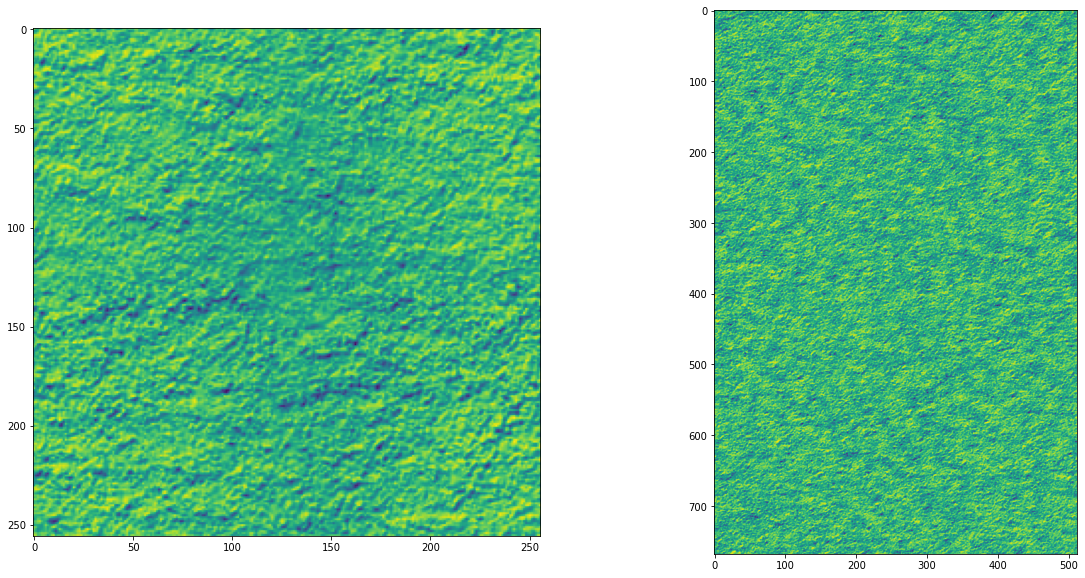

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[1].imshow(image_synth)

# Extending to color space

In [108]:
import numpy as np
from sklearn.decomposition import PCA
import cv2

# Step 1: Load and preprocess the image
image_path = 'test/paper3.png'
original_image = cv2.imread(image_path)

# Step 2: Convert RGB to PCA Color Space
# Reshape the image to a 2D array (pixels as rows, color channels as columns)
pixels = original_image.reshape((-1, 3))

# Perform PCA
num_components = 3  # Number of principal components to retain
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(pixels)

# Step 3: Determine Channels in PCA Color Space
# The channels in the PCA color space are the transformed features along the principal components
pca_channels = pca_result[:, :num_components]

# Now, pca_channels contains the channels in the PCA color space
pca_channels_synth = []
for channel in range(3):
    pca_channels_synth.append(heeger_bergen_texture_synthesis(pca_channels[:, channel].reshape(*original_image.shape[:2]), P, Q, Niter))


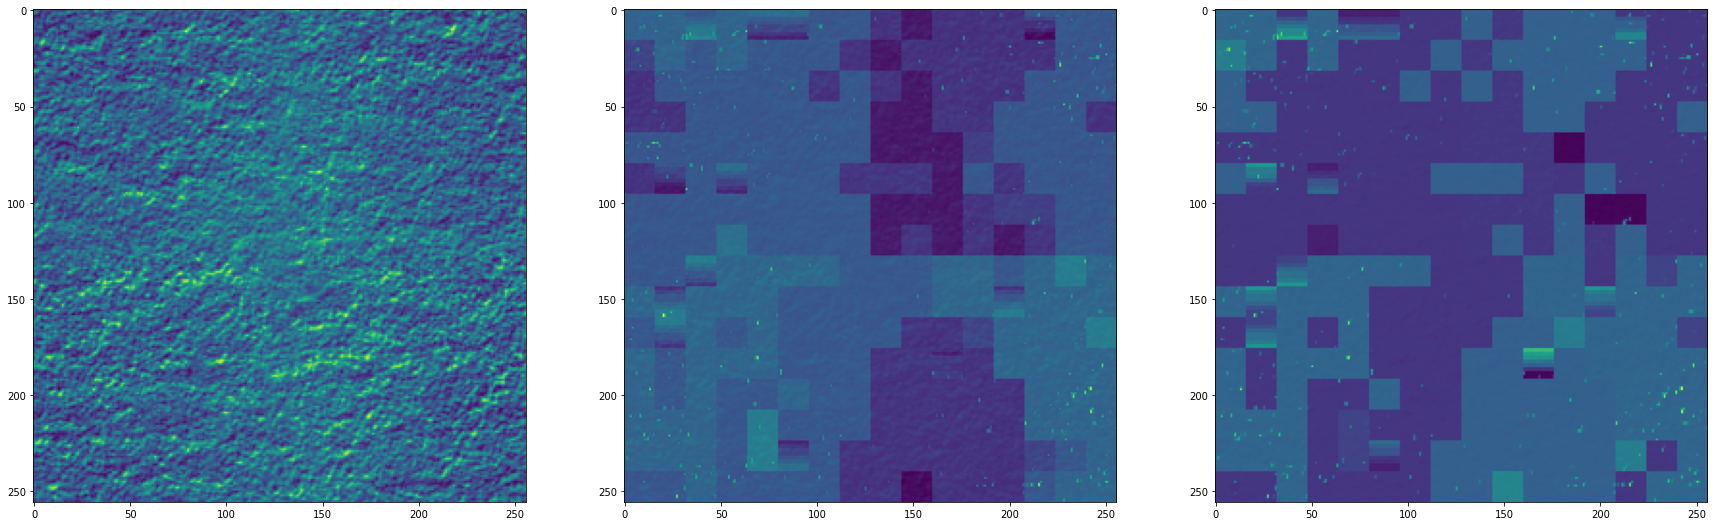

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for channel in range(3):
    ax[channel].imshow(pca_channels[:, channel].reshape(*original_image.shape[:2]))


I'm not sure if we can use pyrtools. If you look at the reconstruction documentaztion, you need to pass in pt.pyramids.SteerablePyramidSpace() object. But when we do histogram matching, we can't turn in that object, but it will rather the coefficient values. Idk if there is a workaround... Need your input Sree.

[Pyrtools](https://pyrtools.readthedocs.io/en/latest/tutorials/03_steerable_pyramids.html#Frequency-domain-construction)

[Pyrtools github](https://github.com/LabForComputationalVision/pyrtools/blob/main/pyrtools/pyramids/SteerablePyramidFreq.py)